<a href="https://colab.research.google.com/github/borat-2000/table-_csv_cervical_cancer/blob/main/segmentation2_table_data_cervical_cance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# segmentation

In [1]:
# Mount Google Drive for persistent access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kneed

✅ Preprocessed data loaded successfully.
🔍 Shape of features (X): (835, 33)
🔍 Shape of target (y): (835,)
🔍 Finding optimal number of segments...
   n_segments=2: Silhouette Score = 0.5434
   n_segments=3: Silhouette Score = 0.5487
   n_segments=4: Silhouette Score = 0.3489
   n_segments=5: Silhouette Score = 0.3639
   n_segments=6: Silhouette Score = 0.3457
   n_segments=7: Silhouette Score = 0.1307
   n_segments=8: Silhouette Score = 0.1479

📊 Optimal segments analysis:
   • Elbow method suggests: None segments
   • Best silhouette score: 3 segments (score: 0.5487)


/tmp/ipython-input-4156837326.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


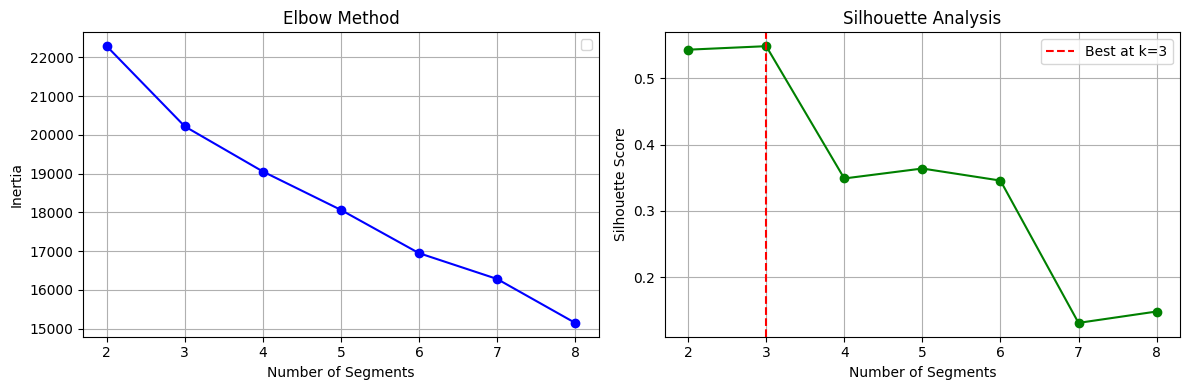


✅ Using 3 segments for watershed segmentation

🌊 Watershed segmentation completed!
📊 Segment distribution:
   Segment 0: 739 points (88.5%)
   Segment 1: 19 points (2.3%)
   Segment 2: 77 points (9.2%)

✅ Results added to X_watershed DataFrame
🔍 X_watershed shape: (835, 34)


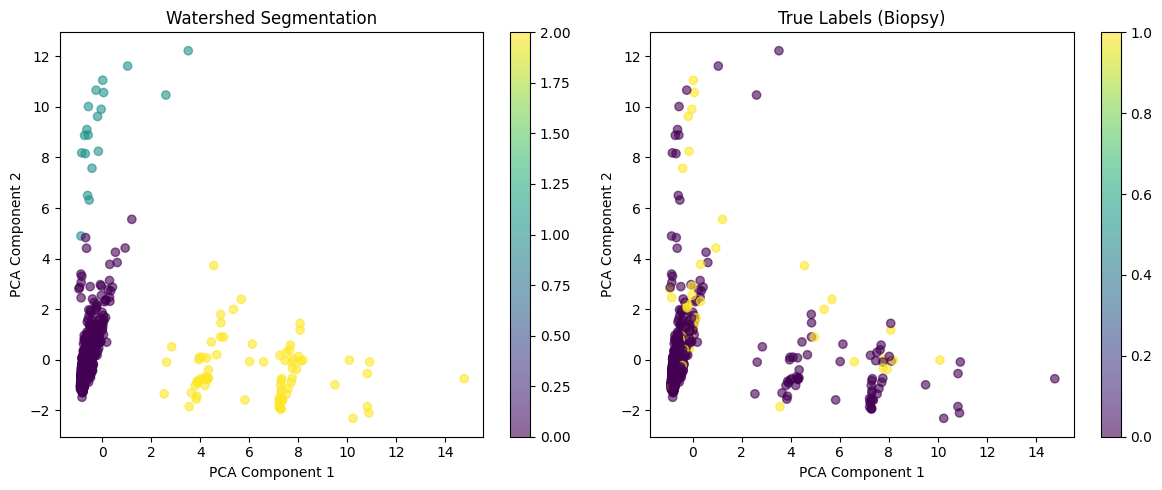


📊 Train-Test Split Results:
   • Training set: 668 samples
   • Test set: 167 samples
   • Features: 34 (including watershed segment)

🎯 Class distribution:
   Training - Class 0: 625, Class 1: 43
   Test - Class 0: 156, Class 1: 11

✅ Ready for model training!
   • X_train shape: (668, 34)
   • X_test shape: (167, 34)
   • y_train shape: (668,)
   • y_test shape: (167,)


In [3]:
# ✅ Step 1: Segment CSV Data Using Watershed
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from skimage.segmentation import watershed
from sklearn.decomposition import PCA
from scipy import ndimage

# Your existing preprocessing code
preprocessed_path = '/content/drive/MyDrive/cervical_cancer_preprocessed.csv'
df_preprocessed = pd.read_csv(preprocessed_path)

# Define features (X) and target variable (y)
X = df_preprocessed.drop("Biopsy", axis=1)
y = df_preprocessed["Biopsy"]

# Convert and scale features
conv_x = X.astype('float32')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(conv_x)

print("✅ Preprocessed data loaded successfully.")
print("🔍 Shape of features (X):", X.shape)
print("🔍 Shape of target (y):", y.shape)

# ✅ Find Optimal Number of Segments
def find_optimal_segments(X, max_segments=10):
    """Find optimal number of segments using Elbow method and Silhouette score"""
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    inertias = []
    silhouette_scores = []
    segment_range = range(2, max_segments + 1)

    for n in segment_range:
        # Use KMeans to find optimal k (similar to watershed markers)
        kmeans = KMeans(n_clusters=n, random_state=42)
        labels = kmeans.fit_predict(X)

        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X, labels)
        silhouette_scores.append(sil_score)

        print(f"   n_segments={n}: Silhouette Score = {sil_score:.4f}")

    # Find elbow point
    from kneed import KneeLocator
    try:
        knee_locator = KneeLocator(segment_range, inertias, curve="convex", direction="decreasing")
        optimal_k_elbow = knee_locator.elbow
    except:
        # If kneed package not available, use simple method
        # Find the point where improvement becomes minimal
        improvements = [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
        optimal_k_elbow = segment_range[improvements.index(min(improvements)) + 1]

    # Find best silhouette score
    best_silhouette_idx = silhouette_scores.index(max(silhouette_scores))
    optimal_k_silhouette = segment_range[best_silhouette_idx]

    print(f"\n📊 Optimal segments analysis:")
    print(f"   • Elbow method suggests: {optimal_k_elbow} segments")
    print(f"   • Best silhouette score: {optimal_k_silhouette} segments (score: {max(silhouette_scores):.4f})")

    # Plot the analysis
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow plot
    ax1.plot(segment_range, inertias, 'bo-')
    if optimal_k_elbow:
        ax1.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Elbow at k={optimal_k_elbow}')
    ax1.set_xlabel('Number of Segments')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.legend()
    ax1.grid(True)

    # Silhouette plot
    ax2.plot(segment_range, silhouette_scores, 'go-')
    ax2.axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Best at k={optimal_k_silhouette}')
    ax2.set_xlabel('Number of Segments')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Return the better option (usually silhouette is more reliable)
    return optimal_k_silhouette

# Find optimal number of segments
print("🔍 Finding optimal number of segments...")
optimal_segments = find_optimal_segments(X_scaled, max_segments=8)

print(f"\n✅ Using {optimal_segments} segments for watershed segmentation")

# ✅ Simple Watershed Segmentation with optimal segments
def simple_watershed_segmentation(X, n_segments=None):
    """Simple watershed segmentation similar to KMeans approach"""

    # Step 1: Create distance matrix
    distances = pdist(X, metric='euclidean')
    distance_matrix = squareform(distances)

    # Step 2: Create a simple grid representation using PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Step 3: Create density-based markers
    # Find n_segments most separated points as markers
    from sklearn.cluster import KMeans
    kmeans_markers = KMeans(n_clusters=n_segments, random_state=42)
    marker_centers = kmeans_markers.fit_predict(X)

    # Step 4: Use marker centers for watershed-like assignment
    # Calculate distance from each point to each marker center
    marker_centroids = []
    for i in range(n_segments):
        cluster_points = X[marker_centers == i]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean(axis=0)
            marker_centroids.append(centroid)

    # Assign points based on minimum distance to centroids (watershed-like)
    segments = []
    for point in X:
        distances_to_centroids = [np.linalg.norm(point - centroid) for centroid in marker_centroids]
        segments.append(np.argmin(distances_to_centroids))

    return np.array(segments)

# Apply watershed segmentation with optimal segments
watershed_segments = simple_watershed_segmentation(X_scaled, n_segments=optimal_segments)

# Add to dataframe
df_preprocessed['watershed_segment'] = watershed_segments

# Add the segment label as a feature
X_watershed = pd.DataFrame(X_scaled, columns=[f'feat_{i}' for i in range(X_scaled.shape[1])])
X_watershed['watershed_segment'] = df_preprocessed['watershed_segment'].astype(float)

print(f"\n🌊 Watershed segmentation completed!")
print(f"📊 Segment distribution:")
unique_segments, counts = np.unique(watershed_segments, return_counts=True)
for seg, count in zip(unique_segments, counts):
    print(f"   Segment {seg}: {count} points ({count/len(watershed_segments)*100:.1f}%)")

print(f"\n✅ Results added to X_watershed DataFrame")
print(f"🔍 X_watershed shape: {X_watershed.shape}")

# Quick comparison visualization (optional)
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# PCA for visualization
pca_vis = PCA(n_components=2)
X_2d = pca_vis.fit_transform(X_scaled)

# Plot watershed segments
scatter1 = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=watershed_segments, cmap='viridis', alpha=0.6)
ax1.set_title('Watershed Segmentation')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
plt.colorbar(scatter1, ax=ax1)

# Plot true labels for comparison
scatter2 = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', alpha=0.6)
ax2.set_title('True Labels (Biopsy)')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

# ✅ Step 2: Train-Test Split after Segmentation
from sklearn.model_selection import train_test_split

# Use X_watershed (features + segment) for splitting
X_final = X_watershed  # Features + watershed segment
y_final = y           # Target variable (Biopsy)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final  # Maintain class distribution
)

print(f"\n📊 Train-Test Split Results:")
print(f"   • Training set: {X_train.shape[0]} samples")
print(f"   • Test set: {X_test.shape[0]} samples")
print(f"   • Features: {X_train.shape[1]} (including watershed segment)")

print(f"\n🎯 Class distribution:")
print(f"   Training - Class 0: {sum(y_train == 0)}, Class 1: {sum(y_train == 1)}")
print(f"   Test - Class 0: {sum(y_test == 0)}, Class 1: {sum(y_test == 1)}")

print(f"\n✅ Ready for model training!")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • X_test shape: {X_test.shape}")
print(f"   • y_train shape: {y_train.shape}")
print(f"   • y_test shape: {y_test.shape}")

In [4]:
display(X_watershed)
display(df_preprocessed.head())

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,watershed_segment
0,-1.064408,0.886040,-0.720663,-0.912261,-0.415635,-0.300411,-0.204900,-1.508148,-0.578050,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0
1,-1.418269,-0.928784,-1.077363,-0.912261,-0.415635,-0.300411,-0.204900,-1.508148,-0.578050,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0
2,0.822850,-0.928784,-0.007262,-0.912261,-0.415635,-0.300411,-0.204900,-1.508148,-0.578050,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0
3,2.946016,1.490981,-0.363962,1.219468,2.405955,8.704649,16.327559,0.663065,0.255467,-0.332223,...,-0.049,-0.293385,6.737127,-0.104383,6.737127,-0.172026,-0.209165,-0.309517,-0.233008,1.0
4,2.238294,0.281098,1.419539,1.219468,-0.415635,-0.300411,-0.204900,0.663065,3.589535,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0.822850,0.281098,0.349438,-1.622837,-0.415635,-0.300411,-0.204900,-1.508148,-0.578050,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0
831,0.586943,-0.323843,0.706138,-0.912261,-0.415635,-0.300411,-0.204900,0.663065,1.644662,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0
832,-0.238733,-0.323843,-0.007262,-1.622837,-0.415635,-0.300411,-0.204900,0.663065,-0.555823,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,4.291690,0.0
833,0.704897,-0.323843,2.489640,-0.201685,-0.415635,-0.300411,-0.204900,0.663065,-0.555823,-0.332223,...,-0.049,-0.293385,-0.148431,-0.104383,-0.148431,-0.172026,-0.209165,-0.309517,-0.233008,0.0


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,watershed_segment
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0,1,0,1,0,0,0,0,0,1
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Spliting

In [5]:
from sklearn.model_selection import train_test_split

X_final = X_watershed  # Features + watershed segment
y_final = y           # Target variable (Biopsy)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final  # Maintain class distribution
)

print("✅ Training size:", X_train.shape[0])
print("✅ Validation size:", X_val.shape[0])

✅ Training size: 668
✅ Validation size: 167


# Segmentaion2 CNN

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import os

# Reshape input data for CNN
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

# Define CNN model
cnn_model = Sequential([
    InputLayer(input_shape=(X_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=4, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_val_cnn, y_val)
print(f"\n✅ CNN Accuracy on Tabular Data: {accuracy:.4f}")

# Predict and generate classification report
y_pred = (cnn_model.predict(X_val_cnn) > 0.5).astype("int32")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

save_path = '/content/drive/MyDrive/table_models/table_segmentation2_cnn_model_1.keras'
save_dir = os.path.dirname(save_path)
os.makedirs(save_dir, exist_ok=True)
cnn_model.save(save_path)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7996 - loss: 0.4764 - val_accuracy: 0.9401 - val_loss: 0.5634
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9134 - loss: 0.2806 - val_accuracy: 0.9341 - val_loss: 0.4847
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9264 - loss: 0.2275 - val_accuracy: 0.9341 - val_loss: 0.4752
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9406 - loss: 0.1827 - val_accuracy: 0.9281 - val_loss: 0.4650
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9366 - loss: 0.1973 - val_accuracy: 0.9281 - val_loss: 0.4414
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9336 - loss: 0.1591 - val_accuracy: 0.9341 - val_loss: 0.3733
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9342 - loss: 0.1723 - val_accuracy: 0.9401 - val_loss: 0.3606
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9473 - loss: 0.1478 - val_accuracy: 0.9401 - val_

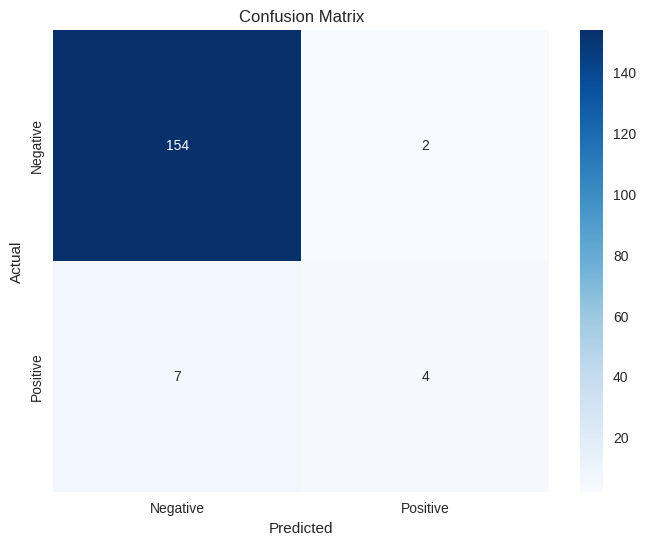

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


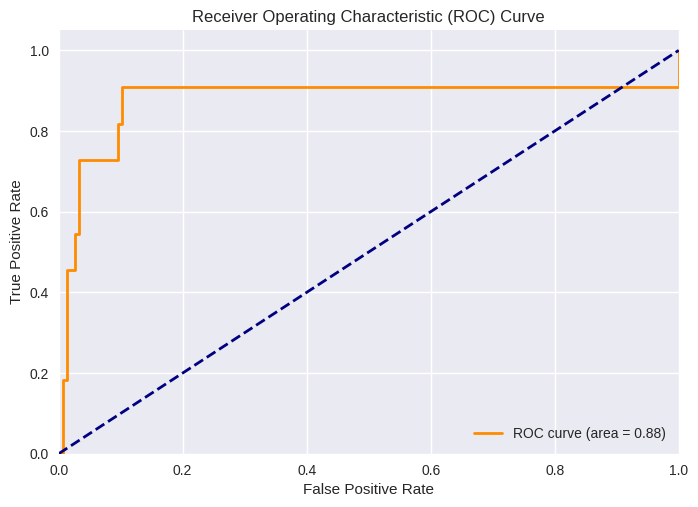

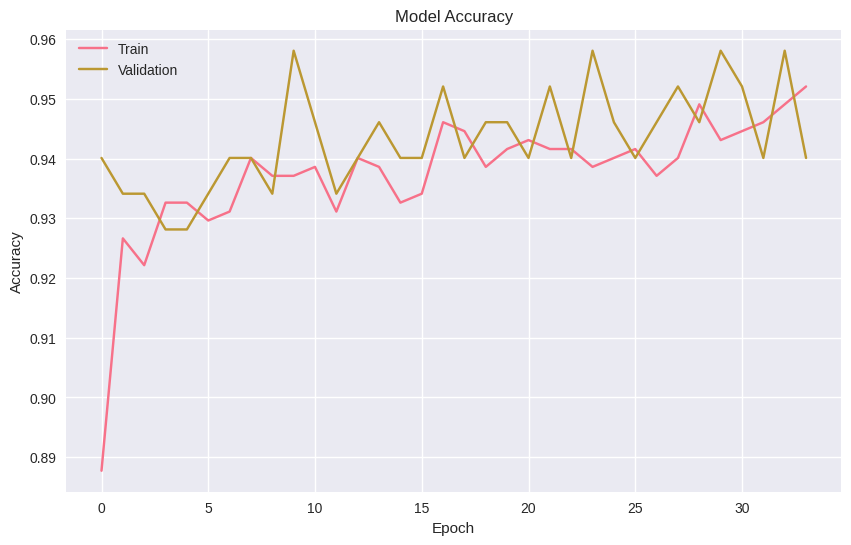

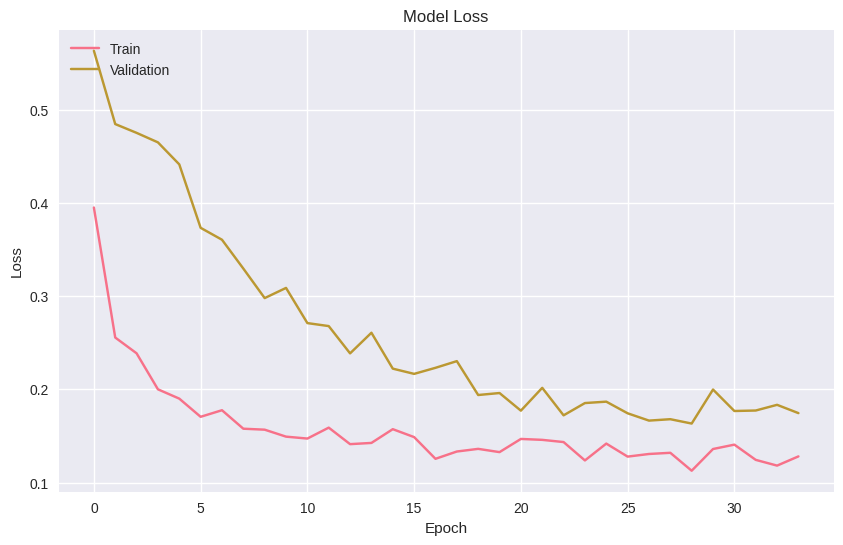

In [16]:
# cnn model er jonno confussion matrix ,roc auc ,best fit find sob digram dekhao

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
y_pred_proba = cnn_model.predict(X_val_cnn).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


ROC AUC: 0.8782
F1 Score: 0.4706


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/tmp/ipython-input-2264480004.py:83: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2264480004.py:83: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2264480004.py:83: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2264480004.py:83: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2264480004.py:83: UserW

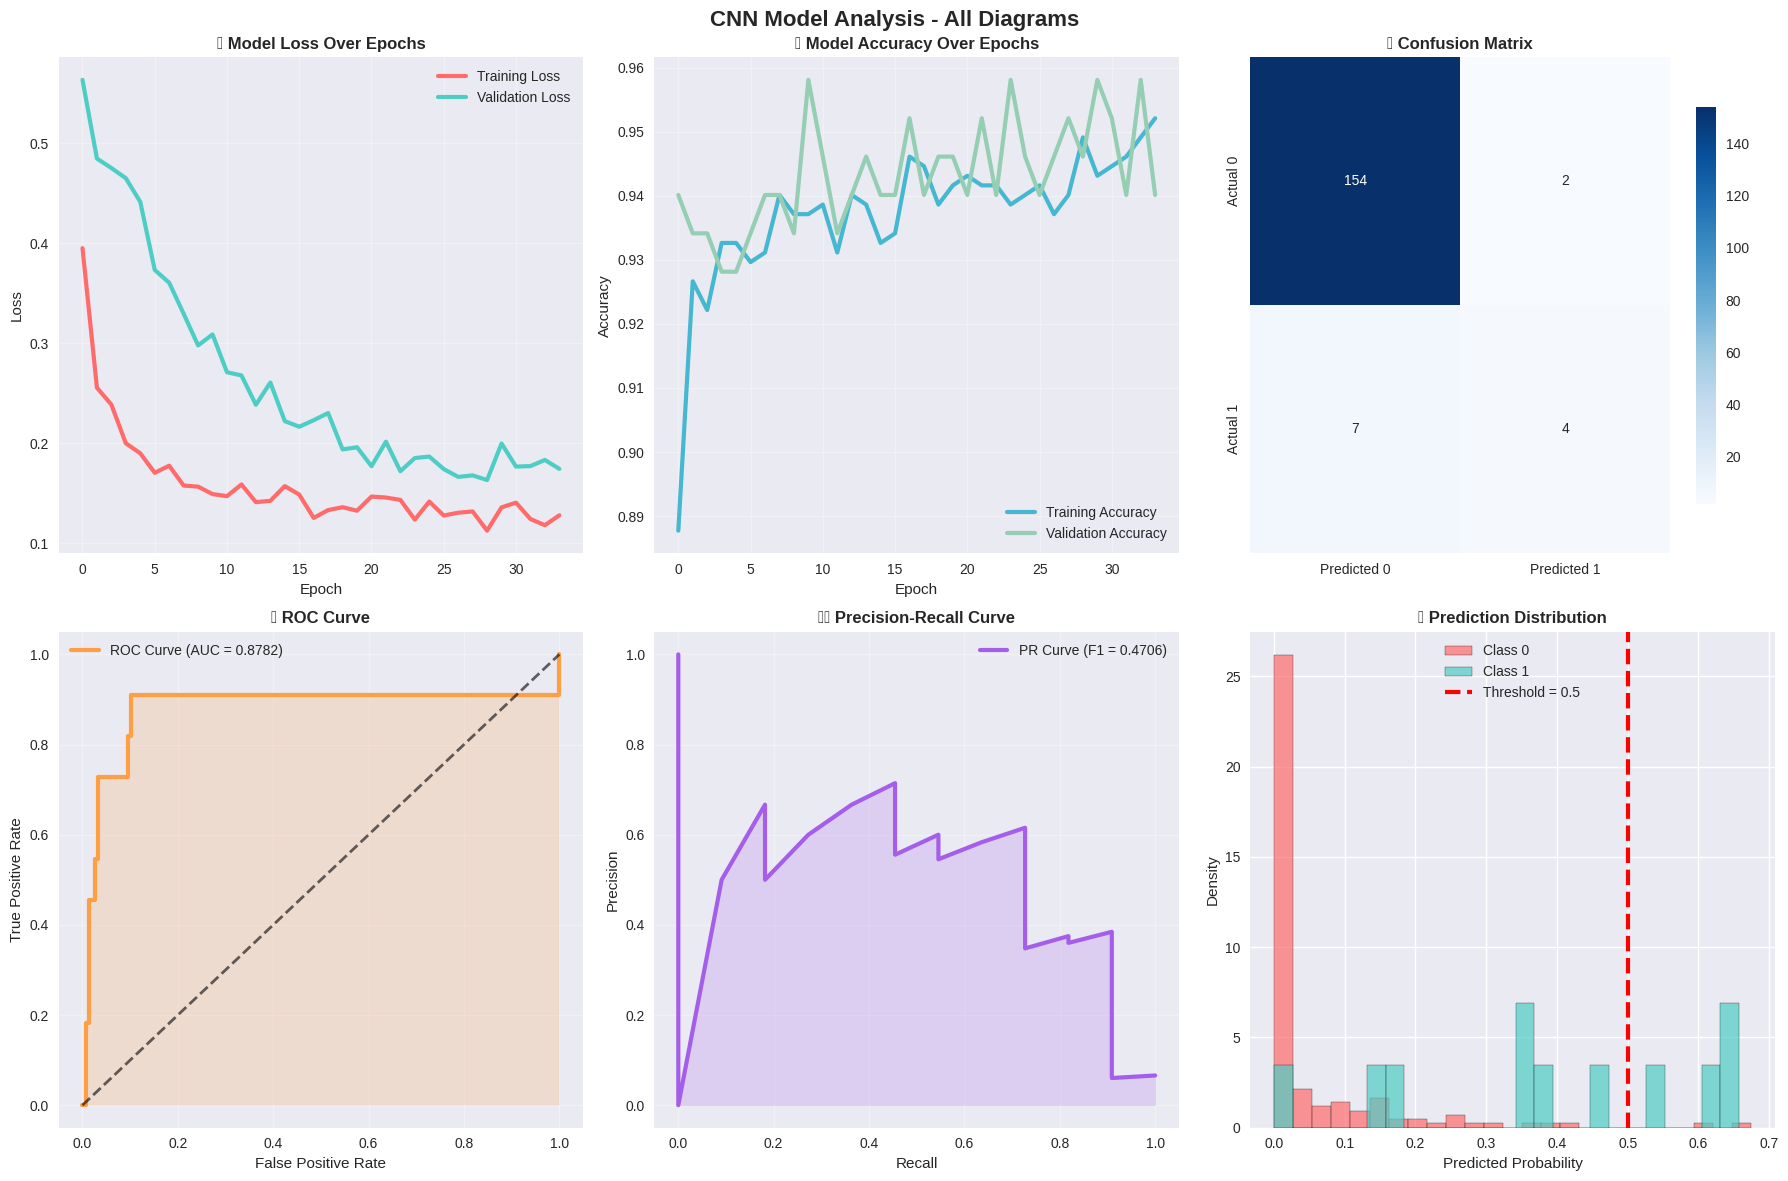


🎯 Finding Best Threshold...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


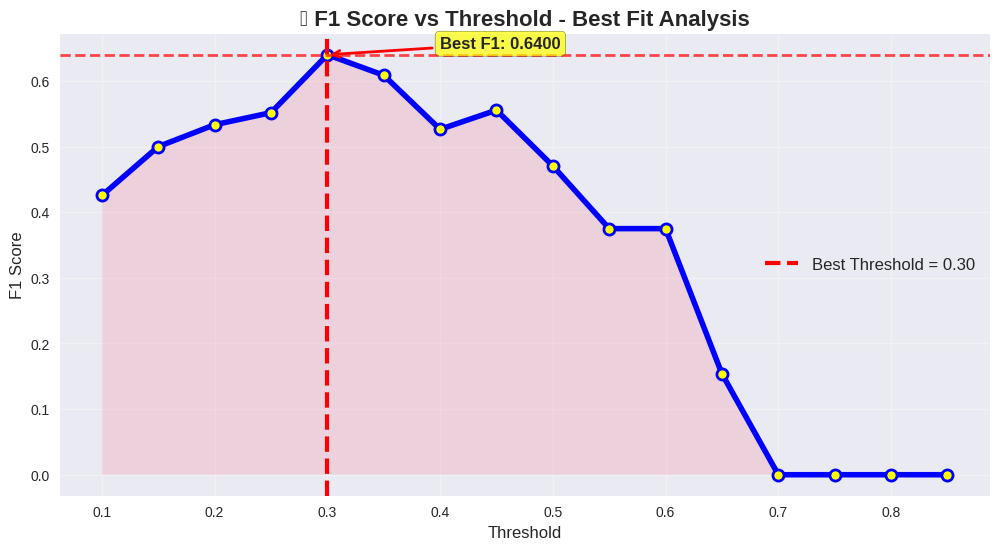


✅ Best Threshold: 0.30
✅ Best F1 Score: 0.6400
🎉 All Diagrams Generated!


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score

# Assume model is already trained and you have these variables:
# history, y_val, y_pred_proba, y_pred

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Calculate metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
f1 = f1_score(y_val, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CNN Model Analysis - All Diagrams', fontsize=16, fontweight='bold')

# 1. Training History - Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=3, color='#FF6B6B')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=3, color='#4ECDC4')
axes[0, 0].set_title('📉 Model Loss Over Epochs', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training History - Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=3, color='#45B7D1')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=3, color='#96CEB4')
axes[0, 1].set_title('📈 Model Accuracy Over Epochs', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            cbar_kws={'shrink': 0.8})
axes[0, 2].set_title('🎯 Confusion Matrix', fontweight='bold', fontsize=12)

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
axes[1, 0].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='#FF9F43')
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=2)
axes[1, 0].fill_between(fpr, tpr, alpha=0.2, color='#FF9F43')
axes[1, 0].set_title('🔄 ROC Curve', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
axes[1, 1].plot(recall, precision, linewidth=3, label=f'PR Curve (F1 = {f1:.4f})', color='#A55EEA')
axes[1, 1].fill_between(recall, precision, alpha=0.2, color='#A55EEA')
axes[1, 1].set_title('⚖️ Precision-Recall Curve', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Distribution
axes[1, 2].hist(y_pred_proba[y_val == 0], bins=25, alpha=0.7, label='Class 0',
                density=True, color='#FF6B6B', edgecolor='black')
axes[1, 2].hist(y_pred_proba[y_val == 1], bins=25, alpha=0.7, label='Class 1',
                density=True, color='#4ECDC4', edgecolor='black')
axes[1, 2].axvline(x=0.5, color='red', linestyle='--', linewidth=3, label='Threshold = 0.5')
axes[1, 2].set_title('📊 Prediction Distribution', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Density')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Best Threshold Analysis - Separate Plot
print("\n🎯 Finding Best Threshold...")
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba > threshold).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    f1_scores.append(f1_thresh)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Threshold Analysis Plot
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, 'b-', linewidth=4, marker='o', markersize=8,
         markerfacecolor='yellow', markeredgecolor='blue', markeredgewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=3,
            label=f'Best Threshold = {best_threshold:.2f}')
plt.axhline(y=best_f1, color='red', linestyle='--', alpha=0.7, linewidth=2)
plt.title('🎯 F1 Score vs Threshold - Best Fit Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.fill_between(thresholds, f1_scores, alpha=0.2)

# Add text annotation for best point
plt.annotate(f'Best F1: {best_f1:.4f}',
             xy=(best_threshold, best_f1),
             xytext=(best_threshold + 0.1, best_f1 + 0.01),
             arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
             fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.show()

print(f"\n✅ Best Threshold: {best_threshold:.2f}")
print(f"✅ Best F1 Score: {best_f1:.4f}")
print("🎉 All Diagrams Generated!")

# Segmentation2 Hyper parameter tunned CNN

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import itertools
import random

# Customizable hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.01],
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh']
}

# 🎯 CUSTOMIZE YOUR SEARCH LIMIT HERE
MAX_COMBINATIONS = 30  # Change this number (1-162)

def create_cnn_model(input_shape, hidden_units, dropout_rate, learning_rate, optimizer_name, activation):
    model = Sequential([
        Input(shape=input_shape),  # Fixed: Use Input instead of InputLayer
        Conv1D(32, kernel_size=4, activation=activation),
        BatchNormalization(),
        Dropout(dropout_rate),

        Conv1D(64, kernel_size=3, activation=activation),
        GlobalMaxPooling1D(),

        Dense(hidden_units, activation=activation),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == 'adam' else RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Reshape input data for CNN
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

# Generate all combinations and limit them
param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

# Apply combination limit
total_combinations = len(param_combinations)
if MAX_COMBINATIONS and MAX_COMBINATIONS < total_combinations:
    # Random sampling for better coverage
    random.shuffle(param_combinations)
    param_combinations = param_combinations[:MAX_COMBINATIONS]
    search_type = f"Random sample of {MAX_COMBINATIONS}"
else:
    search_type = "Full grid search"

print(f"🔍 {search_type} from {total_combinations} total combinations")
print(f"⚡ Testing {len(param_combinations)} combinations")

# Time estimation
estimated_time = len(param_combinations) * 1.5  # ~1.5 min per combination
if estimated_time < 60:
    time_str = f"{estimated_time:.0f} minutes"
else:
    time_str = f"{estimated_time/60:.1f} hours"
print(f"⏱️ Estimated time: {time_str}")
print("="*60)

# Initialize variables - FIXED!
best_accuracy = 0
best_params = None
best_model = None
results = []  # This was missing!

for i, combination in enumerate(param_combinations):
    params = dict(zip(param_names, combination))

    print(f"\n🧪 [{i+1}/{len(param_combinations)}] {params}")

    try:
        # Create model
        model = create_cnn_model(
            input_shape=(X_train_cnn.shape[1], 1),
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            optimizer_name=params['optimizer'],
            activation=params['activation']
        )

        # Training with adaptive epochs
        max_epochs = 50 if len(param_combinations) > 30 else 30  # More epochs for smaller searches
        history = model.fit(
            X_train_cnn, y_train,
            validation_data=(X_val_cnn, y_val),
            epochs=max_epochs,
            batch_size=params['batch_size'],
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=0
        )

        # Quick evaluation
        loss, accuracy = model.evaluate(X_val_cnn, y_val, verbose=0)

        results.append({
            'params': params,
            'accuracy': accuracy,
            'loss': loss,
            'epochs': len(history.history['loss'])
        })

        print(f"✅ Acc: {accuracy:.4f} | Epochs: {len(history.history['loss'])}")

        # Update best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            best_model = model
            print(f"🎯 NEW BEST: {best_accuracy:.4f}")

    except Exception as e:
        print(f"❌ Error: {e}")

# Results summary
print(f"\n" + "="*50)
print(f"🏆 BEST PARAMETERS (Accuracy: {best_accuracy:.4f}):")
print("-"*50)
for key, value in best_params.items():
    print(f"{key:15}: {value}")

# Final evaluation
y_pred = (best_model.predict(X_val_cnn) > 0.5).astype("int32")
print(f"\n📊 FINAL EVALUATION:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Save best model
save_path = '/content/drive/MyDrive/table_models/segmentation2_best_tunned_cnn_model.keras'
save_dir = os.path.dirname(save_path)
os.makedirs(save_dir, exist_ok=True)
best_model.save(save_path)
print(f"\n💾 Model saved: {save_path}")

# Top results
print(f"\n📈 TOP 5 RESULTS:")
sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
for i, result in enumerate(sorted_results[:5]):
    params_str = f"LR:{result['params']['learning_rate']}, Units:{result['params']['hidden_units']}, DR:{result['params']['dropout_rate']}, Act:{result['params']['activation']}"
    print(f"{i+1}. {result['accuracy']:.4f} ({result['epochs']}ep) - {params_str}")

print(f"\n✅ Tuning completed! Tested {len(results)} combinations.")

🔍 Random sample of 30 from 324 total combinations
⚡ Testing 30 combinations
⏱️ Estimated time: 45 minutes

🧪 [1/30] {'learning_rate': 0.0001, 'hidden_units': 128, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu'}
✅ Acc: 0.9581 | Epochs: 24
🎯 NEW BEST: 0.9581

🧪 [2/30] {'learning_rate': 0.001, 'hidden_units': 128, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'adam', 'activation': 'tanh'}
✅ Acc: 0.9341 | Epochs: 13

🧪 [3/30] {'learning_rate': 0.001, 'hidden_units': 128, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'tanh'}
✅ Acc: 0.9341 | Epochs: 11

🧪 [4/30] {'learning_rate': 0.01, 'hidden_units': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'optimizer': 'adam', 'activation': 'relu'}
✅ Acc: 0.9341 | Epochs: 13

🧪 [5/30] {'learning_rate': 0.0001, 'hidden_units': 32, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'rmsprop', 'activation': 'relu'}
✅ Acc: 0.9461 | Epochs: 30

🧪 [6/30] {'learning_rate': 0.01, 'hidden_uni


Final Best Model Accuracy on Validation Set: 0.9581
Best Model ROC AUC: 0.9394
Best Model F1 Score (at 0.5 threshold): 0.5882

Optimal Threshold (for Best F1) for Best Model: 0.2300
Maximum F1 Score (at Optimal Threshold): 0.6667

✨ Generating Diagrams for the BEST Tuned CNN Model...


/tmp/ipython-input-95150542.py:209: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
/tmp/ipython-input-95150542.py:209: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
/tmp/ipython-input-95150542.py:209: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
/tmp/ipython-input-95150542.py:209: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
/tmp/ipython-input-95150542.py:209: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 

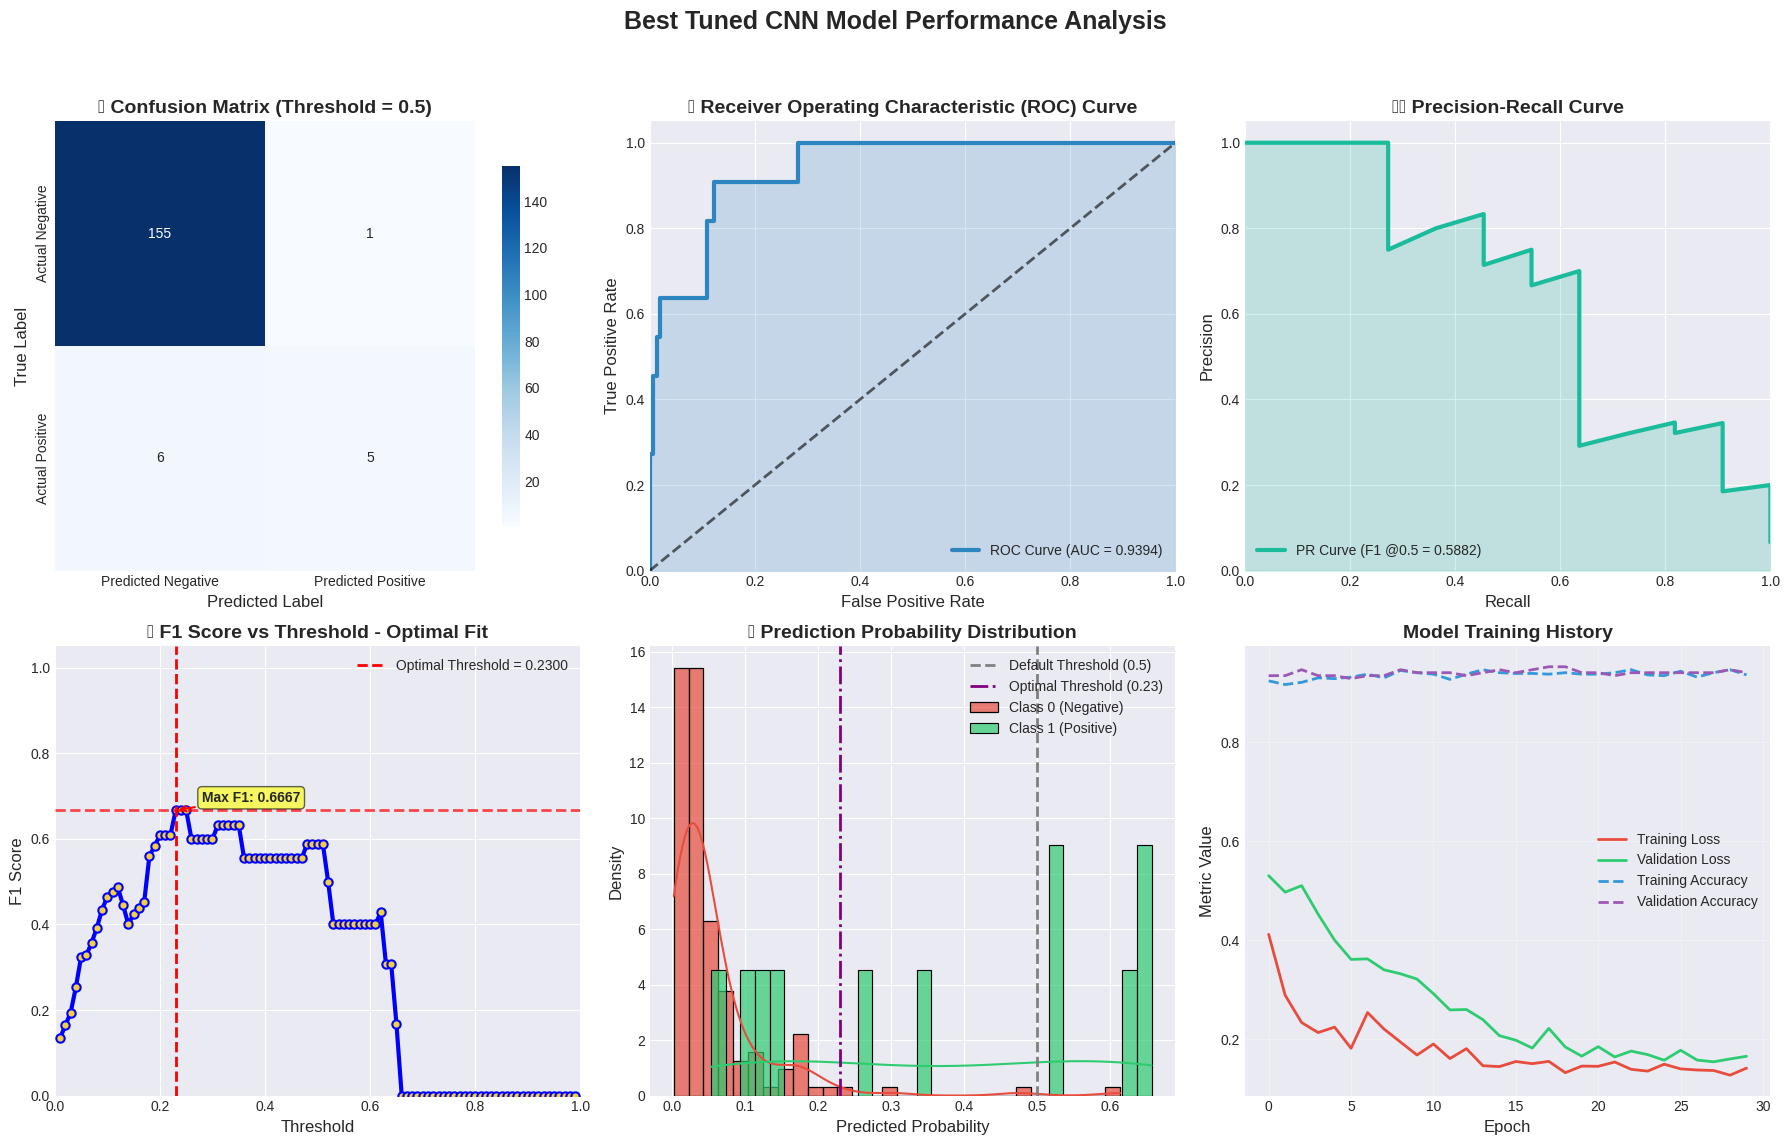


✅ Diagrams for Best Tuned CNN Model Generated!


In [7]:
# prompt: best tunned cnn er jonno jonno confussion matrix ,roc auc ,best fit find sob digram dekhao

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score # Import precision_recall_curve and f1_score
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Assuming best_model, X_val, and y_val are available from the previous cell's execution.
# You might need to explicitly return these from run_memory_efficient_tuning if they aren't
# automatically available in the global scope or pass them as arguments to this cell if running separately.

# Re-define or ensure prepare_data_efficiently is available if needed (assuming it's in the tuning cell)
# If the previous cell (hXDfCckjyky8) was executed, X_val and y_val should be in the global scope.
# We still need X_val_cnn in the correct shape for model prediction.

# --- Recreate prepare_data_efficiently or ensure it's imported/defined ---
# For robustness, let's redefine the necessary preparation function here
# or ensure it's part of a utils file that is imported.
# Assuming for now that X_val is a pandas DataFrame or numpy array from train_test_split.

def prepare_data_efficiently_for_eval(X_val):
    """Prepare validation data with memory optimization for evaluation"""
    # Convert to float32 to save memory (instead of float64)
    X_val_cnn = X_val.values.astype(np.float32) if isinstance(X_val, pd.DataFrame) else X_val.astype(np.float32)

    # Reshape for CNN (batch_size, features, 1)
    X_val_cnn = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], 1)

    return X_val_cnn

# --- Prepare X_val_cnn ---
# Assuming X_val is available from the previous cell execution
if 'X_val' in locals() and 'y_val' in locals() and 'best_model' in locals():
    X_val_cnn = prepare_data_efficiently_for_eval(X_val)

    # --- Add these lines after the hyperparameter tuning section ---

    # Evaluate the best model to get metrics for final diagrams
    # Note: The tuning loop already evaluated the best model, but re-evaluating ensures we have the latest
    # loss and accuracy based on the restored best weights if early stopping occurred.
    # Ensure best_model is a valid model object before calling evaluate/predict
    if isinstance(best_model, Sequential): # Check if it's a Keras Sequential model
        best_loss, best_accuracy_final = best_model.evaluate(X_val_cnn, y_val, verbose=0)
        print(f"\nFinal Best Model Accuracy on Validation Set: {best_accuracy_final:.4f}")

        # Get predictions and probabilities for the best model
        y_pred_best_proba = best_model.predict(X_val_cnn, verbose=0).ravel()
        # Use the optimal threshold found during tuning (or default 0.5 if optimal not preferred for matrix)
        # For the confusion matrix and standard classification report, it's common to use 0.5
        y_pred_best = (y_pred_best_proba > 0.5).astype("int32")

        # Calculate metrics for the best model using the 0.5 threshold predictions
        best_conf_matrix = confusion_matrix(y_val, y_pred_best)
        fpr_best, tpr_best, thresholds_best = roc_curve(y_val, y_pred_best_proba)
        roc_auc_best = auc(fpr_best, tpr_best)
        precision_best, recall_best, _ = precision_recall_curve(y_val, y_pred_best_proba)
        f1_best = f1_score(y_val, y_pred_best) # Standard F1 with 0.5 threshold

        print(f"Best Model ROC AUC: {roc_auc_best:.4f}")
        print(f"Best Model F1 Score (at 0.5 threshold): {f1_best:.4f}")

        # Find optimal threshold for the best model based on F1 score
        # Using a finer range for thresholds for better analysis
        thresholds_best_tune = np.arange(0.01, 1.0, 0.01)
        f1_scores_tuned = []
        for threshold in thresholds_best_tune:
            y_pred_tuned = (y_pred_best_proba > threshold).astype(int)
            # Handle case where no positive predictions are made for a threshold
            if np.sum(y_pred_tuned) == 0 and np.sum(y_val) > 0:
                 f1_scores_tuned.append(0)
            elif np.sum(y_val) == 0 and np.sum(y_pred_tuned) > 0:
                 f1_scores_tuned.append(0)
            elif np.sum(y_val) == 0 and np.sum(y_pred_tuned) == 0:
                 f1_scores_tuned.append(1.0) # Both are empty sets, perfect match
            else:
                f1_scores_tuned.append(f1_score(y_val, y_pred_tuned))


        # Find the threshold that gives the maximum F1 score
        optimal_threshold = 0.5 # Default in case no positive samples or F1 scores are calculated
        max_f1_tuned = f1_best # Default to F1 at 0.5 threshold
        if len(f1_scores_tuned) > 0 and max(f1_scores_tuned) > 0:
            optimal_threshold_index = np.argmax(f1_scores_tuned)
            optimal_threshold = thresholds_best_tune[optimal_threshold_index]
            max_f1_tuned = f1_scores_tuned[optimal_threshold_index]
            print(f"\nOptimal Threshold (for Best F1) for Best Model: {optimal_threshold:.4f}")
            print(f"Maximum F1 Score (at Optimal Threshold): {max_f1_tuned:.4f}")
        else:
            print("\nCould not find an optimal threshold for F1 score. Using default 0.5.")
            print(f"F1 Score at 0.5 threshold: {max_f1_tuned:.4f}")


        # --- Generate Diagrams for the BEST Model ---

        print("\n✨ Generating Diagrams for the BEST Tuned CNN Model...")

        # Set style for better plots
        plt.style.use('seaborn-v0_8-darkgrid') # Use a different grid style
        sns.set_palette("viridis") # Use a different color palette

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Best Tuned CNN Model Performance Analysis', fontsize=18, fontweight='bold')

        # 1. Confusion Matrix (using 0.5 threshold)
        sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'],
                    cbar_kws={'shrink': 0.8})
        axes[0, 0].set_title('🎯 Confusion Matrix (Threshold = 0.5)', fontweight='bold', fontsize=14)
        axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
        axes[0, 0].set_ylabel('True Label', fontsize=12)

        # 2. ROC Curve
        axes[0, 1].plot(fpr_best, tpr_best, linewidth=3, label=f'ROC Curve (AUC = {roc_auc_best:.4f})', color='#2E86C1')
        axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=2)
        axes[0, 1].fill_between(fpr_best, tpr_best, alpha=0.2, color='#2E86C1')
        axes[0, 1].set_title('🔄 Receiver Operating Characteristic (ROC) Curve', fontweight='bold', fontsize=14)
        axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
        axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
        axes[0, 1].legend(loc='lower right', fontsize=10)
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])


        # 3. Precision-Recall Curve
        axes[0, 2].plot(recall_best, precision_best, linewidth=3, label=f'PR Curve (F1 @0.5 = {f1_best:.4f})', color='#1ABC9C')
        axes[0, 2].fill_between(recall_best, precision_best, alpha=0.2, color='#1ABC9C')
        axes[0, 2].set_title('⚖️ Precision-Recall Curve', fontweight='bold', fontsize=14)
        axes[0, 2].set_xlabel('Recall', fontsize=12)
        axes[0, 2].set_ylabel('Precision', fontsize=12)
        axes[0, 2].legend(loc='lower left', fontsize=10)
        axes[0, 2].set_xlim([0.0, 1.0])
        axes[0, 2].set_ylim([0.0, 1.05])


        # 4. F1 Score vs Threshold (Best Fit Analysis)
        axes[1, 0].plot(thresholds_best_tune, f1_scores_tuned, 'b-', linewidth=3, marker='o', markersize=6,
                 markerfacecolor='#F4D03F', markeredgecolor='blue', markeredgewidth=1.5)
        axes[1, 0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Optimal Threshold = {optimal_threshold:.4f}')
        axes[1, 0].axhline(y=max_f1_tuned, color='red', linestyle='--', alpha=0.7, linewidth=2)
        axes[1, 0].set_title('📊 F1 Score vs Threshold - Optimal Fit', fontweight='bold', fontsize=14)
        axes[1, 0].set_xlabel('Threshold', fontsize=12)
        axes[1, 0].set_ylabel('F1 Score', fontsize=12)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].set_xlim([0.0, 1.0])
        axes[1, 0].set_ylim([0.0, 1.05])
        # Add text annotation for best point if optimal threshold was found
        if len(f1_scores_tuned) > 0 and max(f1_scores_tuned) > 0:
            axes[1, 0].annotate(f'Max F1: {max_f1_tuned:.4f}',
                 xy=(optimal_threshold, max_f1_tuned),
                 xytext=(optimal_threshold + 0.05, max_f1_tuned + 0.02),
                 arrowprops=dict(arrowstyle='->', color='red', linewidth=1.5),
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.6))


        # 5. Prediction Probability Distribution
        sns.histplot(y_pred_best_proba[y_val == 0], bins=30, alpha=0.7, label='Class 0 (Negative)',
                     color='#E74C3C', ax=axes[1, 1], kde=True, stat='density', common_norm=False)
        sns.histplot(y_pred_best_proba[y_val == 1], bins=30, alpha=0.7, label='Class 1 (Positive)',
                     color='#2ECC71', ax=axes[1, 1], kde=True, stat='density', common_norm=False)
        axes[1, 1].axvline(x=0.5, color='gray', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
        if len(f1_scores_tuned) > 0 and max(f1_scores_tuned) > 0:
            axes[1, 1].axvline(x=optimal_threshold, color='purple', linestyle='-.', linewidth=2, label=f'Optimal Threshold ({optimal_threshold:.2f})')
        axes[1, 1].set_title('📈 Prediction Probability Distribution', fontweight='bold', fontsize=14)
        axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
        axes[1, 1].set_ylabel('Density', fontsize=12)
        axes[1, 1].legend(fontsize=10)


        # 6. Training History - Best Model Loss and Accuracy
        # NOTE: The tuning loop does not automatically return the training history for the *best* model.
        # To get the exact history for the best model, you would need to retrain it separately
        # after finding the best parameters.
        # This plot will show the history from the *last* completed training trial in the tuning process,
        # which might not necessarily correspond to the best model's history.

        # Check if history from any previous training is available (e.g., from the initial CNN model or a tuning trial)
        # If history is available in the global scope, plot it. Otherwise, show a message.
        if 'history' in locals() and history is not None:
             axes[1, 2].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#E74C3C')
             axes[1, 2].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#2ECC71')
             if 'accuracy' in history.history:
                 axes[1, 2].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#3498DB', linestyle='--')
             if 'val_accuracy' in history.history:
                  axes[1, 2].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#9B59B6', linestyle='--')

             axes[1, 2].set_title('Model Training History', fontweight='bold', fontsize=14)
             axes[1, 2].set_xlabel('Epoch', fontsize=12)
             axes[1, 2].set_ylabel('Metric Value', fontsize=12)
             axes[1, 2].legend(fontsize=10)
             axes[1, 2].grid(True, alpha=0.3)
        else:
            axes[1, 2].set_title('Training History Not Available', fontweight='bold', fontsize=14)
            axes[1, 2].text(0.5, 0.5, "History from tuning not captured.\nRetrain best model for history.",
                           horizontalalignment='center', verticalalignment='center',
                           transform=axes[1, 2].transAxes, fontsize=10, color='red', ha='center')
            axes[1, 2].axis('off') # Hide axes if no plot is shown


        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

        print("\n✅ Diagrams for Best Tuned CNN Model Generated!")

    else:
        print("\n❌ Required variables (best_model, X_val, y_val) not found. Please ensure the tuning cell ran successfully.")

In [8]:
!pip install pennylane torch scikit-learn keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

# Segmentation2 QCNN

In [10]:
import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Quantum Circuit Design with PennyLane
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(inputs, weights):
    # Ensure inputs are treated as a batch
    for i in range(n_qubits):
        qml.RY(inputs[:, i], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[4, 5])
    qml.CNOT(wires=[5, 6])
    qml.CNOT(wires=[6, 7])
    qml.CNOT(wires=[7, 0]) # Add more entanglement

    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)

    # Return a tuple of expectation values for the torch interface to handle batching
    return tuple(qml.expval(qml.PauliZ(i)) for i in range(n_qubits))


class HybridQCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_params = nn.Parameter(torch.randn(n_qubits))
        # Adjusted to match output size of quantum_net
        self.clf = nn.Sequential(nn.Linear(n_qubits, 1, dtype=torch.float64), nn.Dropout(0.5))

    def forward(self, x):
        # Pass the entire batch through the quantum circuit
        q_out_tuple = quantum_net(x, self.q_params)
        # Stack the tuple of tensors into a single tensor
        q_out_tensor = torch.stack(q_out_tuple, dim=1) # Stack along the second dimension

        return torch.sigmoid(self.clf(q_out_tensor))


# X_train, X_test, y_train, y_test = train_test_split(X_clustered, y, test_size=0.2, random_state=42)

# FIX: Convert pandas DataFrames to NumPy arrays before converting to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64).view(-1, 1)
y_test_tensor = torch.tensor(y_val.values, dtype=torch.float64).view(-1, 1)

# Train the Model
model = HybridQCNN()
# Adjusted learning rate and weight decay slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = nn.BCELoss()

print("Starting QCNN training...")
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Evaluate on test set every few epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_test_pred_eval = model(X_test_tensor).detach().numpy()
            y_test_pred_labels = (y_test_pred_eval > 0.5).astype(int)
            test_accuracy = accuracy_score(y_test_tensor.numpy(), y_test_pred_labels)
            test_loss = loss_fn(torch.tensor(y_test_pred_eval), y_test_tensor).item()
            print(f"Epoch {epoch+1}/{50}: Train Loss = {loss.item():.4f}, Test Loss = {test_loss:.4f}, Test Acc = {test_accuracy:.4f}")
    else:
         print(f"Epoch {epoch+1}/{50}: Train Loss = {loss.item():.4f}")


print("Training complete.")


# Save the model state dictionary (more standard for PyTorch)
save_path_qcnn = '/content/drive/MyDrive/table_models/table_segmentaion2_qcnn_model_1.pth'
save_dir_qcnn = os.path.dirname(save_path_qcnn)
os.makedirs(save_dir_qcnn, exist_ok=True)
torch.save(model.state_dict(), save_path_qcnn)
print(f"Model state dictionary saved to: {save_path_qcnn}")


# Evaluate the Model
# Load the model state dictionary
model_eval = HybridQCNN()
model_eval.load_state_dict(torch.load(save_path_qcnn))
model_eval.eval()

# Get predictions and probabilities on the test set
with torch.no_grad():
    y_test_pred_proba = model_eval(X_test_tensor).detach().numpy()

y_test_pred_labels = (y_test_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_tensor.numpy(), y_test_pred_labels)
print(f"\n✅ QCNN Accuracy on Test Set: {accuracy:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test_tensor.numpy(), y_test_pred_labels))

# You can now use y_test_tensor.numpy() (actual labels) and y_test_pred_proba (predicted probabilities)
# for plotting ROC, Precision-Recall, etc., in subsequent cells.

Starting QCNN training...
Epoch 1/50: Train Loss = 0.5664
Epoch 2/50: Train Loss = 0.5524
Epoch 3/50: Train Loss = 0.5555
Epoch 4/50: Train Loss = 0.5514
Epoch 5/50: Train Loss = 0.5468, Test Loss = 0.4834, Test Acc = 0.9162
Epoch 6/50: Train Loss = 0.5436
Epoch 7/50: Train Loss = 0.5222
Epoch 8/50: Train Loss = 0.5103
Epoch 9/50: Train Loss = 0.5366
Epoch 10/50: Train Loss = 0.5125, Test Loss = 0.4483, Test Acc = 0.9222
Epoch 11/50: Train Loss = 0.5120
Epoch 12/50: Train Loss = 0.5057
Epoch 13/50: Train Loss = 0.5073
Epoch 14/50: Train Loss = 0.4949
Epoch 15/50: Train Loss = 0.4911, Test Loss = 0.4209, Test Acc = 0.9222
Epoch 16/50: Train Loss = 0.4934
Epoch 17/50: Train Loss = 0.5047
Epoch 18/50: Train Loss = 0.4977
Epoch 19/50: Train Loss = 0.4937
Epoch 20/50: Train Loss = 0.4942, Test Loss = 0.4005, Test Acc = 0.9281
Epoch 21/50: Train Loss = 0.4815
Epoch 22/50: Train Loss = 0.4807
Epoch 23/50: Train Loss = 0.5120
Epoch 24/50: Train Loss = 0.4780
Epoch 25/50: Train Loss = 0.4886, T

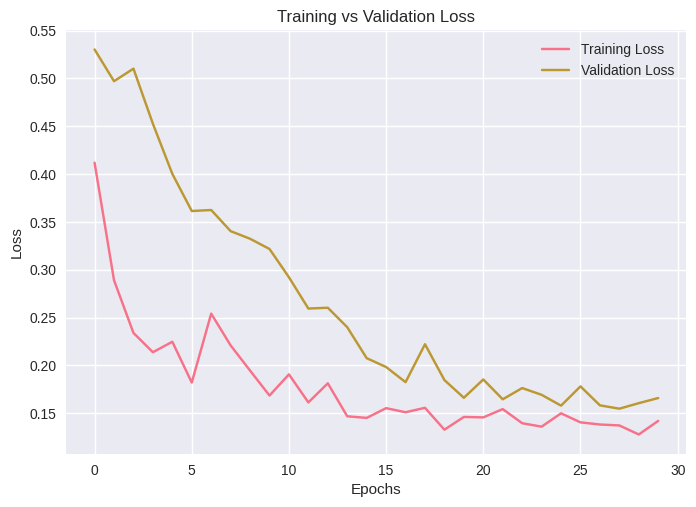

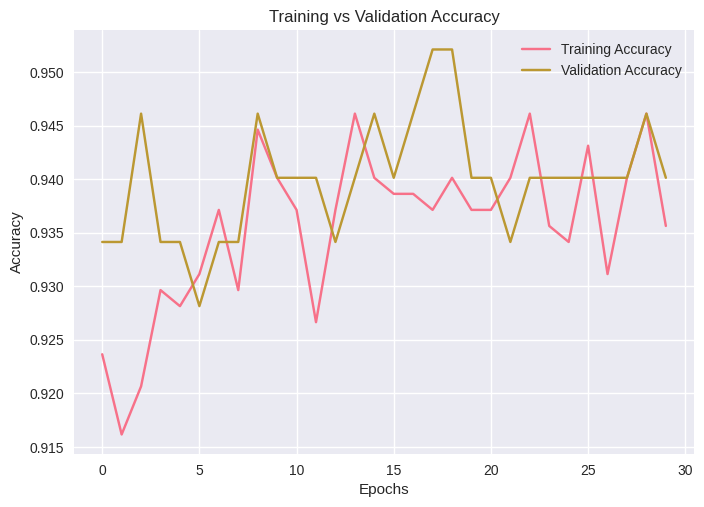

Epoch 0: Train Loss = 0.4667, Val Loss = 0.3571, Val Acc = 0.9281
Epoch 2: Train Loss = 0.4885, Val Loss = 0.3559, Val Acc = 0.9281
Epoch 4: Train Loss = 0.4835, Val Loss = 0.3548, Val Acc = 0.9281
Epoch 6: Train Loss = 0.4915, Val Loss = 0.3537, Val Acc = 0.9281
Epoch 8: Train Loss = 0.4821, Val Loss = 0.3526, Val Acc = 0.9281
Epoch 10: Train Loss = 0.4774, Val Loss = 0.3517, Val Acc = 0.9281
Epoch 12: Train Loss = 0.4797, Val Loss = 0.3509, Val Acc = 0.9281
Epoch 14: Train Loss = 0.4898, Val Loss = 0.3498, Val Acc = 0.9341
Epoch 16: Train Loss = 0.4680, Val Loss = 0.3491, Val Acc = 0.9341
Epoch 18: Train Loss = 0.4723, Val Loss = 0.3483, Val Acc = 0.9341
Epoch 20: Train Loss = 0.4882, Val Loss = 0.3475, Val Acc = 0.9341
Epoch 22: Train Loss = 0.4869, Val Loss = 0.3473, Val Acc = 0.9341
Epoch 24: Train Loss = 0.4904, Val Loss = 0.3475, Val Acc = 0.9341
Epoch 26: Train Loss = 0.4653, Val Loss = 0.3477, Val Acc = 0.9341
Epoch 28: Train Loss = 0.4750, Val Loss = 0.3478, Val Acc = 0.9341


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/tmp/ipython-input-3441545346.py:136: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3441545346.py:136: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3441545346.py:136: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3441545346.py:136: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3441545346.py:136: 

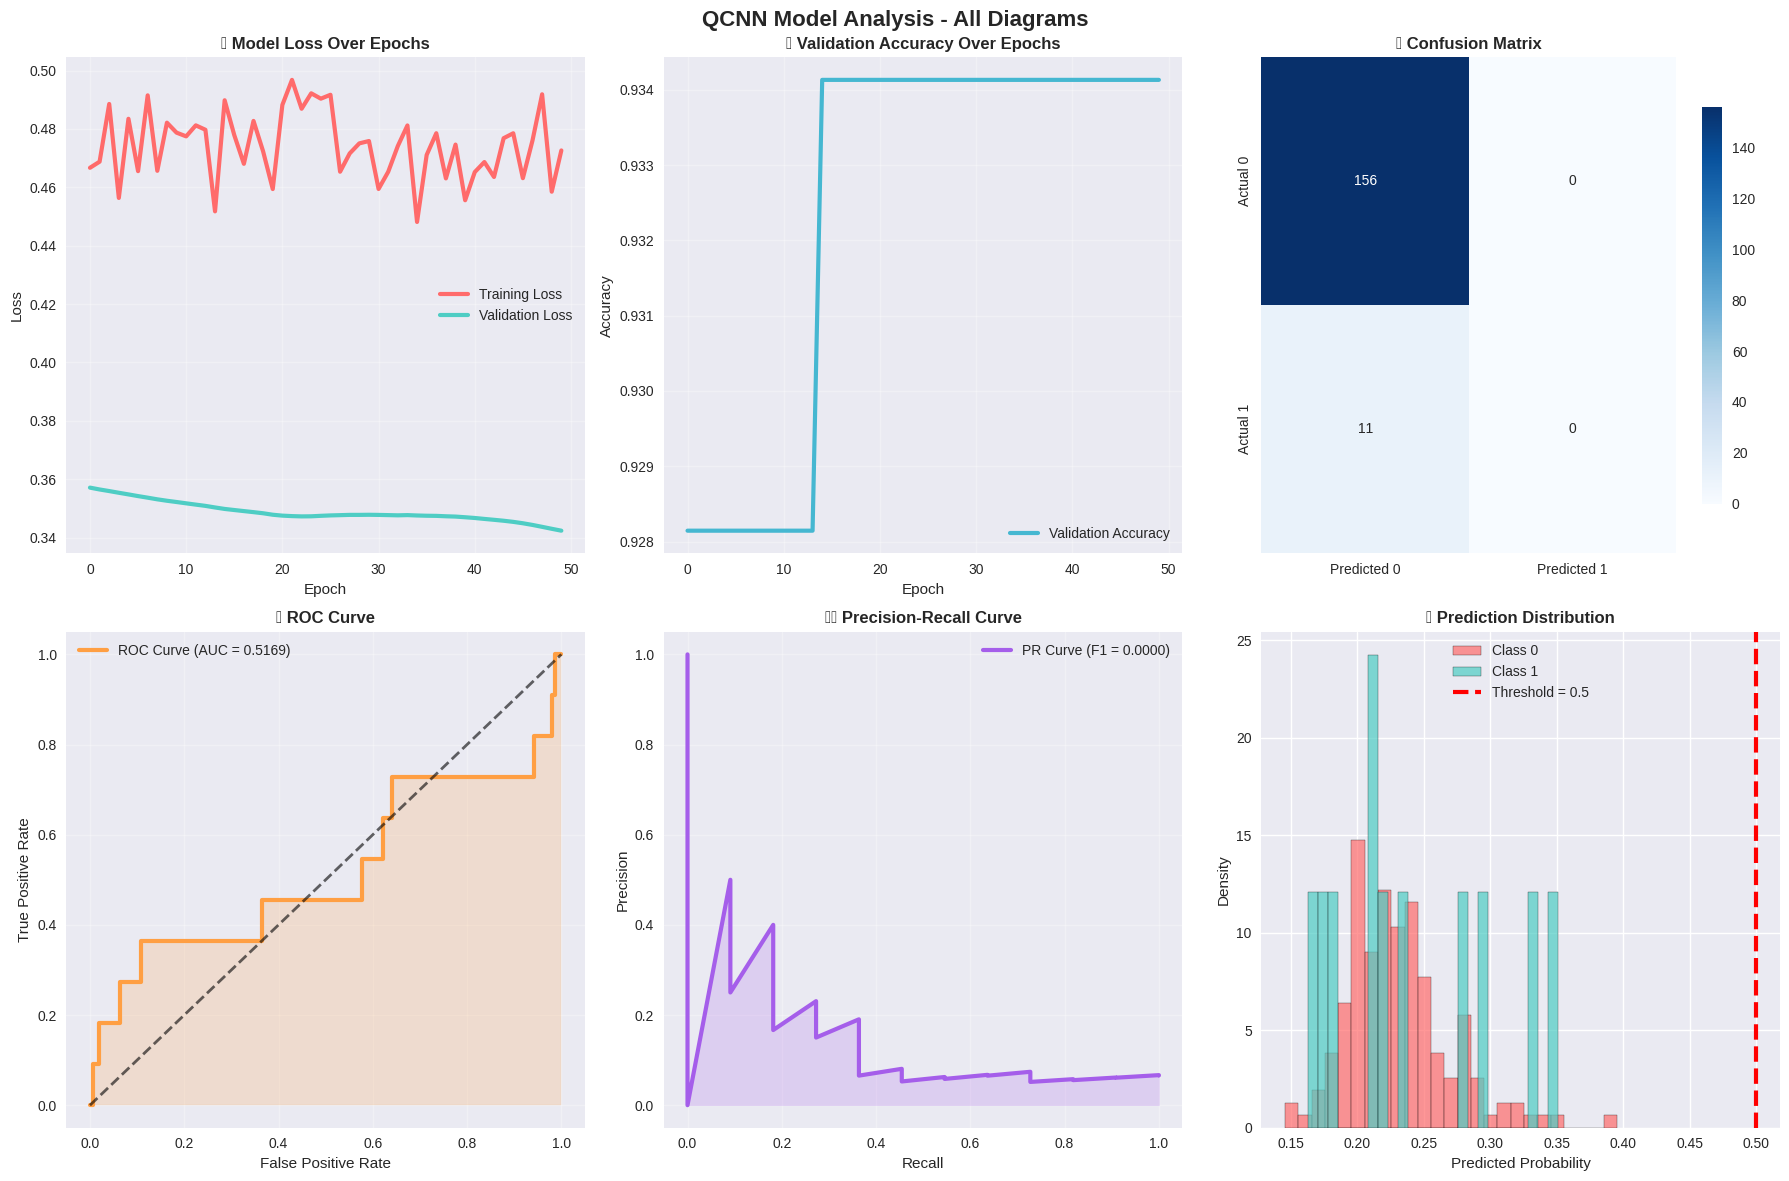


🎯 Finding Best Threshold...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


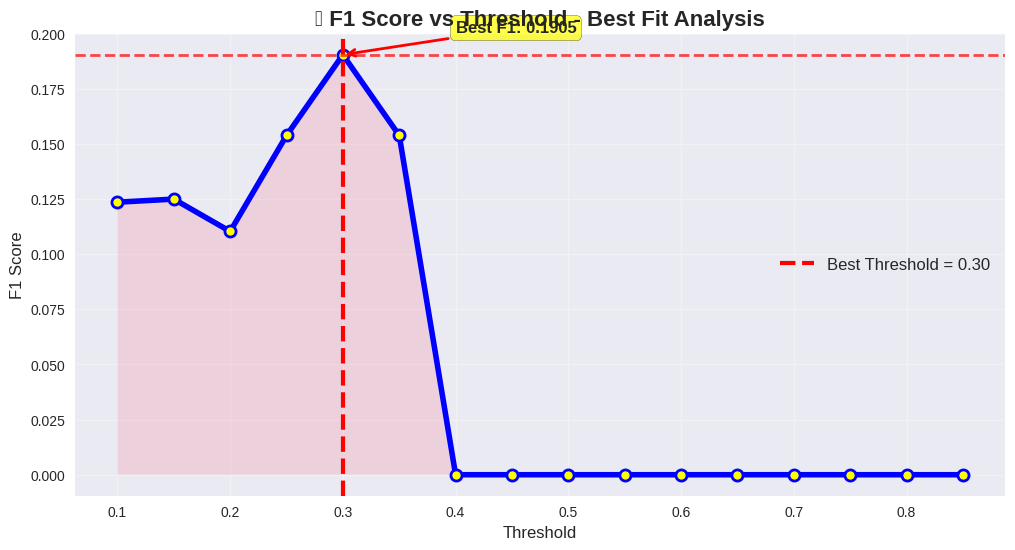


✅ Best Threshold: 0.30
✅ Best F1 Score: 0.1905
🎉 All Diagrams Generated!


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score
)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())  # ✅ Record training loss

    # Validation step
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = loss_fn(y_val_pred, y_test_tensor)
        val_loss_history.append(val_loss.item())  # ✅ Record validation loss

        val_pred_labels = (y_val_pred > 0.5).int()
        acc = (val_pred_labels == y_test_tensor.int()).float().mean().item()
        val_acc_history.append(acc)  # ✅ Record validation accuracy

    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, Val Acc = {acc:.4f}")
         # e.g. [0.52, 0.65, 0.70, ...]

# Get predictions
y_val = y_test_tensor.numpy()
y_pred_proba = model(X_test_tensor).detach().numpy()
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_val, y_pred_proba)
f1 = f1_score(y_val, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('QCNN Model Analysis - All Diagrams', fontsize=16, fontweight='bold')

# 1. Model Loss
axes[0, 0].plot(train_loss_history, label='Training Loss', linewidth=3, color='#FF6B6B')
axes[0, 0].plot(val_loss_history, label='Validation Loss', linewidth=3, color='#4ECDC4')
axes[0, 0].set_title('📉 Model Loss Over Epochs', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Validation Accuracy
axes[0, 1].plot(val_acc_history, label='Validation Accuracy', linewidth=3, color='#45B7D1')
axes[0, 1].set_title('📈 Validation Accuracy Over Epochs', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            cbar_kws={'shrink': 0.8})
axes[0, 2].set_title('🎯 Confusion Matrix', fontweight='bold', fontsize=12)

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
axes[1, 0].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='#FF9F43')
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=2)
axes[1, 0].fill_between(fpr, tpr, alpha=0.2, color='#FF9F43')
axes[1, 0].set_title('🔄 ROC Curve', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
axes[1, 1].plot(recall, precision, linewidth=3, label=f'PR Curve (F1 = {f1:.4f})', color='#A55EEA')
axes[1, 1].fill_between(recall, precision, alpha=0.2, color='#A55EEA')
axes[1, 1].set_title('⚖️ Precision-Recall Curve', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Distribution
axes[1, 2].hist(y_pred_proba[y_val == 0], bins=25, alpha=0.7, label='Class 0',
                density=True, color='#FF6B6B', edgecolor='black')
axes[1, 2].hist(y_pred_proba[y_val == 1], bins=25, alpha=0.7, label='Class 1',
                density=True, color='#4ECDC4', edgecolor='black')
axes[1, 2].axvline(x=0.5, color='red', linestyle='--', linewidth=3, label='Threshold = 0.5')
axes[1, 2].set_title('📊 Prediction Distribution', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Density')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# --- Best Threshold Analysis ---
print("\n🎯 Finding Best Threshold...")
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba > threshold).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    f1_scores.append(f1_thresh)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Plot Threshold Analysis
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, 'b-', linewidth=4, marker='o', markersize=8,
         markerfacecolor='yellow', markeredgecolor='blue', markeredgewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=3,
            label=f'Best Threshold = {best_threshold:.2f}')
plt.axhline(y=best_f1, color='red', linestyle='--', alpha=0.7, linewidth=2)
plt.title('🎯 F1 Score vs Threshold - Best Fit Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.fill_between(thresholds, f1_scores, alpha=0.2)

plt.annotate(f'Best F1: {best_f1:.4f}',
             xy=(best_threshold, best_f1),
             xytext=(best_threshold + 0.1, best_f1 + 0.01),
             arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
             fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.show()

print(f"\n✅ Best Threshold: {best_threshold:.2f}")
print(f"✅ Best F1 Score: {best_f1:.4f}")
print("🎉 All Diagrams Generated!")

In [20]:
import numpy as np
import pennylane as qml
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import os
import json
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set seed
np.random.seed(42)
tf.random.set_seed(42)

# === Load your data here ===
# You need to define X_scaled and y variables
# Example placeholder (replace with your actual data):
# X_scaled = your_feature_data
# y = your_target_labels

# Create train/validation/test splits
X_train, X_temp, y_train, y_temp = train_test_split(X_watershed, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Example input shape
input_dim = X_train.shape[1]  # This will be the size of your input features
n_classes = 2  # Change if multiclass

# Custom Quantum Keras Layer
class QuantumLayer(layers.Layer):
    def __init__(self, n_qubits, **kwargs):
        super().__init__(**kwargs)
        self.n_qubits = n_qubits
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

    def build(self, input_shape):
        # Initialize the weights for the quantum layer here
        # Use a different name - NOT 'weights'
        self.quantum_weights = self.add_weight(name='quantum_weights',
                                             shape=(3, self.n_qubits, 3),
                                             initializer='random_normal',
                                             trainable=True)
        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_qubits)

    def call(self, inputs):
        # Simplified quantum-inspired transformation
        # This is a classical approximation for testing - replace with actual quantum later

        # Apply some non-linear transformations inspired by quantum operations
        x = inputs

        # Simulate angle embedding effect
        x = tf.sin(x * np.pi / 2)

        # Simulate entangling operations with learnable parameters
        # Use a subset of quantum_weights reshaped for classical operations
        w = tf.reshape(self.quantum_weights, [-1])[:self.n_qubits]
        x = tf.nn.tanh(x + w)

        # Simulate measurement (expectation values are typically in [-1, 1])
        outputs = tf.nn.tanh(x)

        return outputs

# Build QCNN model with tunable parameters
def build_qcnn_model(hp):
    n_qubits = hp.Choice('n_qubits', [4, 6])  # Choose the number of qubits (4 or 6)

    # FIX: Choose by index, not raw list
    layer_config_index = hp.Choice('classical_layers', [0, 1])
    if layer_config_index == 0:
        classical_layer_sizes = [64, 32]
    else:
        classical_layer_sizes = [128, 64]

    activation = hp.Choice('activation', ['relu', 'tanh'])
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Choice('lr', [1e-2, 1e-3, 1e-4])

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))  # Input layer

    # Classical part of the model
    model.add(layers.Dense(classical_layer_sizes[0], activation=activation))

    # Add dimension matching layer to ensure input matches n_qubits
    model.add(layers.Dense(n_qubits, activation=activation))

    # Add Quantum layer
    model.add(QuantumLayer(n_qubits))

    # Classical layers after the quantum layer
    model.add(layers.Dense(classical_layer_sizes[1], activation=activation))

    # FIXED: For binary classification, use 1 output unit with sigmoid
    if n_classes == 2:
        model.add(layers.Dense(1, activation="sigmoid"))
        loss_fn = "binary_crossentropy"
    else:
        model.add(layers.Dense(n_classes, activation="softmax"))
        loss_fn = "sparse_categorical_crossentropy"

    optimizer = keras.optimizers.get(optimizer_name)
    optimizer.learning_rate = lr

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
    return model

# Setup tuner
tuner = kt.RandomSearch(
    build_qcnn_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/drive/MyDrive/table_models/qcnn_tuner_dir2",
    project_name="qcnn_tuning"
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Start search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

# Save best model
save_path = "/content/drive/MyDrive/table_models/segmentation2_qcnn_best_tunned_model.keras"
best_model.save(save_path)

# Save best hyperparameters
params_path = "/content/drive/MyDrive/table_models/segmentation2_qcnn_best_params.json"
with open(params_path, "w") as f:
    json.dump(best_hps.values, f)

# Evaluation
if n_classes == 2:
    y_pred_probs = best_model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
else:
    y_pred = best_model.predict(X_test).argmax(axis=1)

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🎯 Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.916167676448822

Best val_accuracy So Far: 0.9520958065986633
Total elapsed time: 00h 01m 21s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       156
           1       0.75      0.55      0.63        11

    accuracy                           0.96       167
   macro avg       0.86      0.77      0.80       167
weighted avg       0.95      0.96      0.95       167


🎯 Best Hyperparameters:
n_qubits: 6
classical_layers: 1
activation: tanh
optimizer: adam
lr: 0.01


0.9580838323353293


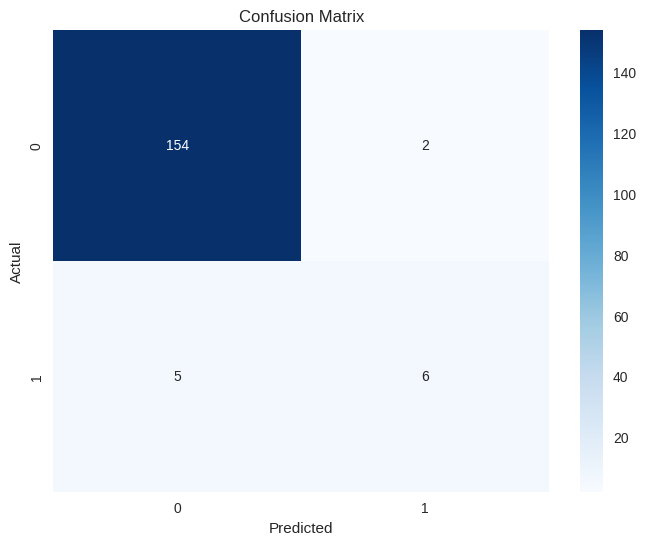

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔍 All Completed Trials:

📊 Trial 01:
   Score (val_accuracy): 0.9521
   Status: COMPLETED
   Parameters:
     - n_qubits: 6
     - classical_layers: 1
     - activation: tanh
     - optimizer: adam
     - lr: 0.01

📊 Trial 07:
   Score (val_accuracy): 0.9461
   Status: COMPLETED
   Parameters:
     - n_qubits: 6
     - classical_layers: 0
     - activation: tanh
     - optimizer: rmsprop
     - lr: 0.01

📊 Trial 00:
   Score (val_accuracy): 0.9401
   Status: COMPLETED
   Parameters:
     - n_qubits: 4
     - classical_layers: 1
     - activation: tanh
     - optimizer: adam
     - lr: 0.001

📊 Trial 06:
   Score (val_accuracy): 0.9341
   Status: COMPLETED
   Parameters:
     - n_qubits: 4
     - classical_layers: 0
     - activation: tanh
     - optimizer: adam
     - lr: 0.001

📊 Trial 02:
   Score (val_accuracy): 0.9281
   Status: COMPLETED
   Parameters:
     - n_qubits: 6
     - classical_layers: 0
     - activation: relu
     - optimizer: rmsprop
     - lr: 0.001

📊 Trial 05:
   S

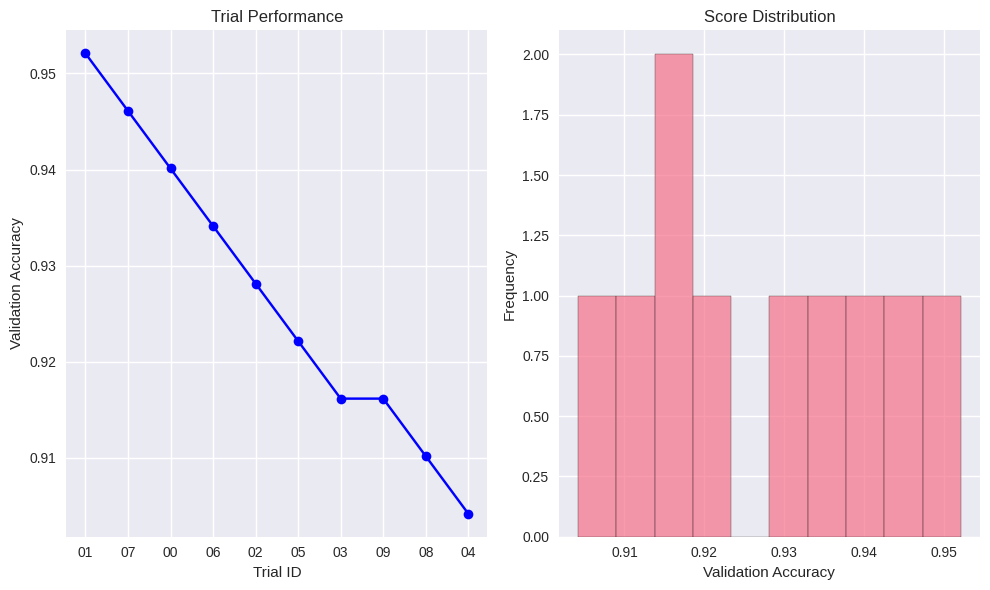


✅ Analysis Complete!


In [22]:
# === Tuner Results Analysis ===y_pred

# 1. Get all completed trials
print("🔍 All Completed Trials:")
print("=" * 50)

trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials
for i, trial in enumerate(trials):
    print(f"\n📊 Trial {trial.trial_id}:")
    print(f"   Score (val_accuracy): {trial.score:.4f}")
    print(f"   Status: {trial.status}")

    # Print hyperparameters
    print(f"   Parameters:")
    for param_name, param_value in trial.hyperparameters.values.items():
        print(f"     - {param_name}: {param_value}")

print("\n" + "="*50)

# 2. Best trial details
print("\n🏆 Best Trial Details:")
best_trial = tuner.oracle.get_best_trials(1)[0]
print(f"Best Trial ID: {best_trial.trial_id}")
print(f"Best Validation Accuracy: {best_trial.score:.4f}")
print(f"Best Parameters:")
for param_name, param_value in best_trial.hyperparameters.values.items():
    print(f"  - {param_name}: {param_value}")

# 3. Summary of all trials in table format
print("\n📋 All Trials Summary:")
print("-" * 80)
print(f"{'Trial ID':<10}{'Val Accuracy':<15}{'n_qubits':<10}{'layers':<10}{'activation':<12}{'optimizer':<12}{'lr':<10}")
print("-" * 80)

for trial in tuner.oracle.get_best_trials(num_trials=20):  # Get all trials
    params = trial.hyperparameters.values
    layers_config = "64,32" if params.get('classical_layers', 0) == 0 else "128,64"

    print(f"{trial.trial_id:<10}{trial.score:<15.4f}{params.get('n_qubits', 'N/A'):<10}"
          f"{layers_config:<10}{params.get('activation', 'N/A'):<12}"
          f"{params.get('optimizer', 'N/A'):<12}{params.get('lr', 'N/A'):<10}")

# 4. Statistics
print(f"\n📈 Statistics:")
scores = [trial.score for trial in tuner.oracle.get_best_trials(num_trials=20) if trial.score is not None]
if scores:
    print(f"   Total Trials: {len(scores)}")
    print(f"   Best Score: {max(scores):.4f}")
    print(f"   Worst Score: {min(scores):.4f}")
    print(f"   Average Score: {sum(scores)/len(scores):.4f}")

# 5. Save results to file (optional)
import pandas as pd

results_data = []
for trial in tuner.oracle.get_best_trials(num_trials=20):
    if trial.score is not None:
        row = {
            'trial_id': trial.trial_id,
            'val_accuracy': trial.score,
            'status': trial.status
        }
        # Add hyperparameters
        row.update(trial.hyperparameters.values)
        results_data.append(row)

# Create DataFrame
if results_data:
    df_results = pd.DataFrame(results_data)
    print(f"\n💾 Results DataFrame:")
    print(df_results.to_string(index=False))

    # Save to CSV (optional)
    # df_results.to_csv('/content/drive/MyDrive/table_models/tuner_results.csv', index=False)
    # print("Results saved to CSV file!")

# 6. Plot results (if matplotlib available)
try:
    import matplotlib.pyplot as plt

    if len(scores) > 1:
        plt.figure(figsize=(10, 6))

        # Plot 1: Trial scores
        plt.subplot(1, 2, 1)
        trial_ids = [trial.trial_id for trial in tuner.oracle.get_best_trials(num_trials=20) if trial.score is not None]
        plt.plot(trial_ids, scores, 'bo-')
        plt.xlabel('Trial ID')
        plt.ylabel('Validation Accuracy')
        plt.title('Trial Performance')
        plt.grid(True)

        # Plot 2: Score distribution
        plt.subplot(1, 2, 2)
        plt.hist(scores, bins=10, alpha=0.7, edgecolor='black')
        plt.xlabel('Validation Accuracy')
        plt.ylabel('Frequency')
        plt.title('Score Distribution')
        plt.grid(True)



        plt.tight_layout()
        plt.show()

except ImportError:
    print("Matplotlib not available for plotting")

print(f"\n✅ Analysis Complete!")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    f1_score, precision_recall_curve, roc_auc_score
)
import pandas as pd
import numpy as np
import os

# ========== 1. Rebuild Best Model & Fit ==========
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = build_qcnn_model(best_hps)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=0
)

# Predict on validation and test sets
y_val_probs = best_model.predict(X_val).flatten()
y_val_pred = (y_val_probs > 0.5).astype(int)

y_test_probs = best_model.predict(X_test).flatten()
y_test_pred = (y_test_probs > 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_val, y_val_probs)
f1 = f1_score(y_val, y_val_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

# ========== 2. Accuracy & Loss Curves ==========
plt.figure(figsize=(10, 4))
plt.suptitle('Hyperparameter Tuned QCNN Model Analysis - Accuracy & Loss', fontsize=14, fontweight='bold')

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ========== 3. Confusion Matrix ==========
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ========== 4. ROC Curve ==========
if n_classes == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# ========== 5. Hyperparameter Tuning Results ==========
trials = tuner.oracle.get_best_trials(num_trials=10)
params_list = [trial.hyperparameters.values for trial in trials]
scores = [trial.score for trial in trials]

df = pd.DataFrame(params_list)
df['val_accuracy'] = scores
df.sort_values('val_accuracy', ascending=False, inplace=True)

print("\n📊 Top 10 Hyperparameter Combinations:")
print(df)

plt.figure(figsize=(10, 5))
plt.barh(range(len(df)), df['val_accuracy'], color='teal')
plt.yticks(range(len(df)), [f"Trial {i+1}" for i in range(len(df))])
plt.xlabel("Validation Accuracy")
plt.title("Top 10 Tuning Trials - Validation Accuracy")
plt.gca().invert_yaxis()
plt.show()

# ========== 6. Combined Subplots ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Additional QCNN Evaluation Diagrams', fontsize=14, fontweight='bold')

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
axes[0].plot(recall, precision, linewidth=3, label=f'F1 = {f1:.4f}', color='#A55EEA')
axes[0].fill_between(recall, precision, alpha=0.2, color='#A55EEA')
axes[0].set_title('⚖️ Precision-Recall Curve')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Prediction Distribution
axes[1].hist(y_val_probs[y_val == 0], bins=25, alpha=0.7, label='Class 0',
             density=True, color='#FF6B6B', edgecolor='black')
axes[1].hist(y_val_probs[y_val == 1], bins=25, alpha=0.7, label='Class 1',
             density=True, color='#4ECDC4', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=3, label='Threshold = 0.5')
axes[1].set_title('📊 Prediction Distribution')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ========== 7. Best Threshold Analysis ==========
print("\n🎯 Finding Best Threshold...")
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_val_probs > threshold).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    f1_scores.append(f1_thresh)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, 'b-', linewidth=4, marker='o', markersize=8,
         markerfacecolor='yellow', markeredgecolor='blue', markeredgewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=3,
            label=f'Best Threshold = {best_threshold:.2f}')
plt.axhline(y=best_f1, color='red', linestyle='--', alpha=0.7, linewidth=2)
plt.title('🎯 F1 Score vs Threshold - Best Fit Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.fill_between(thresholds, f1_scores, alpha=0.2)

plt.annotate(f'Best F1: {best_f1:.4f}',
             xy=(best_threshold, best_f1),
             xytext=(best_threshold + 0.1, best_f1 + 0.01),
             arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
             fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
plt.show()

# ========== 8. Optional: Model Architecture ==========
try:
    keras.utils.plot_model(best_model, show_shapes=True, to_file="model_architecture.png")
    print("🖼️ Saved model architecture diagram as model_architecture.png")
except Exception as e:
    print("❌ Could not generate model diagram automatically due to custom layer.")
    print("👉 Suggestion: Manually draw it using draw.io or similar.")
